# Basic model with static forcing

In [1]:
# | include: false
import os

os.environ["USE_PYGEOS"] = "0"

In [2]:
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ribasim

Setup the basins:

In [3]:
profile = pd.DataFrame(
    data={
        "node_id": [1, 1, 3, 3, 6, 6, 9, 9],
        "area": [0.01, 1000.0] * 4,
        "level": [0.0, 1.0] * 4,
    }
)

# Convert steady forcing to m/s
# 2 mm/d precipitation, 1 mm/d evaporation
seconds_in_day = 24 * 3600
precipitation = 0.002 / seconds_in_day
evaporation = 0.001 / seconds_in_day

static = pd.DataFrame(
    data={
        "node_id": [0],
        "drainage": [0.0],
        "potential_evaporation": [evaporation],
        "infiltration": [0.0],
        "precipitation": [precipitation],
        "urban_runoff": [0.0],
    }
)
static = static.iloc[[0, 0, 0, 0]]
static["node_id"] = [1, 3, 6, 9]

basin = ribasim.Basin(profile=profile, static=static)

Setup linear resistance:

In [4]:
linear_resistance = ribasim.LinearResistance(
    static=pd.DataFrame(
        data={"node_id": [10, 12], "resistance": [5e3, (3600.0 * 24) / 100.0]}
    )
)

Setup Manning resistance:

In [5]:
manning_resistance = ribasim.ManningResistance(
    static=pd.DataFrame(
        data={
            "node_id": [2],
            "length": [900.0],
            "manning_n": [0.04],
            "profile_width": [6.0],
            "profile_slope": [3.0],
        }
    )
)

Set up a rating curve node:

In [6]:
# Discharge: lose 1% of storage volume per day at storage = 1000.0.
q1000 = 1000.0 * 0.01 / seconds_in_day

rating_curve = ribasim.TabulatedRatingCurve(
    static=pd.DataFrame(
        data={
            "node_id": [4, 4],
            "level": [0.0, 1.0],
            "discharge": [0.0, q1000],
        }
    )
)

Setup fractional flows:

In [7]:
fractional_flow = ribasim.FractionalFlow(
    static=pd.DataFrame(
        data={
            "node_id": [5, 8, 13],
            "fraction": [0.3, 0.6, 0.1],
        }
    )
)

Setup pump:

In [8]:
pump = ribasim.Pump(
    static=pd.DataFrame(
        data={
            "node_id": [7],
            "flow_rate": [0.5 / 3600],
        }
    )
)

Setup level boundary:

In [9]:
level_boundary = ribasim.LevelBoundary(
    static=pd.DataFrame(
        data={
            "node_id": [11, 17],
            "level": [0.5, 1.5],
        }
    )
)

Setup flow boundary:

In [10]:
flow_boundary = ribasim.FlowBoundary(
    static=pd.DataFrame(
        data={
            "node_id": [15, 16],
            "flow_rate": [1e-4, 1e-4],
        }
    )
)

Setup terminal:

In [11]:
terminal = ribasim.Terminal(
    static=pd.DataFrame(
        data={
            "node_id": [14],
        }
    )
)

Set up the nodes:

In [12]:
xy = np.array(
    [
        (0.0, 0.0),  # 1: Basin,
        (1.0, 0.0),  # 2: ManningResistance
        (2.0, 0.0),  # 3: Basin
        (3.0, 0.0),  # 4: TabulatedRatingCurve
        (3.0, 1.0),  # 5: FractionalFlow
        (3.0, 2.0),  # 6: Basin
        (4.0, 1.0),  # 7: Pump
        (4.0, 0.0),  # 8: FractionalFlow
        (5.0, 0.0),  # 9: Basin
        (6.0, 0.0),  # 10: LinearResistance
        (2.0, 2.0),  # 11: LevelBoundary
        (2.0, 1.0),  # 12: LinearResistance
        (3.0, -1.0),  # 13: FractionalFlow
        (3.0, -2.0),  # 14: Terminal
        (3.0, 3.0),  # 15: FlowBoundary
        (0.0, 1.0),  # 16: FlowBoundary
        (6.0, 1.0),  # 17: LevelBoundary
    ]
)
node_xy = gpd.points_from_xy(x=xy[:, 0], y=xy[:, 1])

node_id, node_type = ribasim.Node.get_node_ids_and_types(
    basin,
    manning_resistance,
    rating_curve,
    pump,
    fractional_flow,
    linear_resistance,
    level_boundary,
    flow_boundary,
    terminal,
)

# Make sure the feature id starts at 1: explicitly give an index.
node = ribasim.Node(
    static=gpd.GeoDataFrame(
        data={"type": node_type},
        index=pd.Index(node_id, name="fid"),
        geometry=node_xy,
        crs="EPSG:28992",
    )
)

Setup the edges:

In [13]:
from_id = np.array(
    [1, 2, 3, 4, 4, 5, 6, 8, 7, 9, 11, 12, 4, 13, 15, 16, 10], dtype=np.int64
)
to_id = np.array(
    [2, 3, 4, 5, 8, 6, 7, 9, 9, 10, 12, 3, 13, 14, 6, 1, 17], dtype=np.int64
)
lines = ribasim.utils.geometry_from_connectivity(node, from_id, to_id)
edge = ribasim.Edge(
    static=gpd.GeoDataFrame(
        data={
            "from_node_id": from_id,
            "to_node_id": to_id,
            "edge_type": len(from_id) * ["flow"],
        },
        geometry=lines,
        crs="EPSG:28992",
    )
)

Setup a model:

In [14]:
model = ribasim.Model(
    node=node,
    edge=edge,
    basin=basin,
    level_boundary=level_boundary,
    flow_boundary=flow_boundary,
    pump=pump,
    linear_resistance=linear_resistance,
    manning_resistance=manning_resistance,
    tabulated_rating_curve=rating_curve,
    fractional_flow=fractional_flow,
    terminal=terminal,
    starttime="2020-01-01 00:00:00",
    endtime="2021-01-01 00:00:00",
)

Let's take a look at the model:

<Axes: >

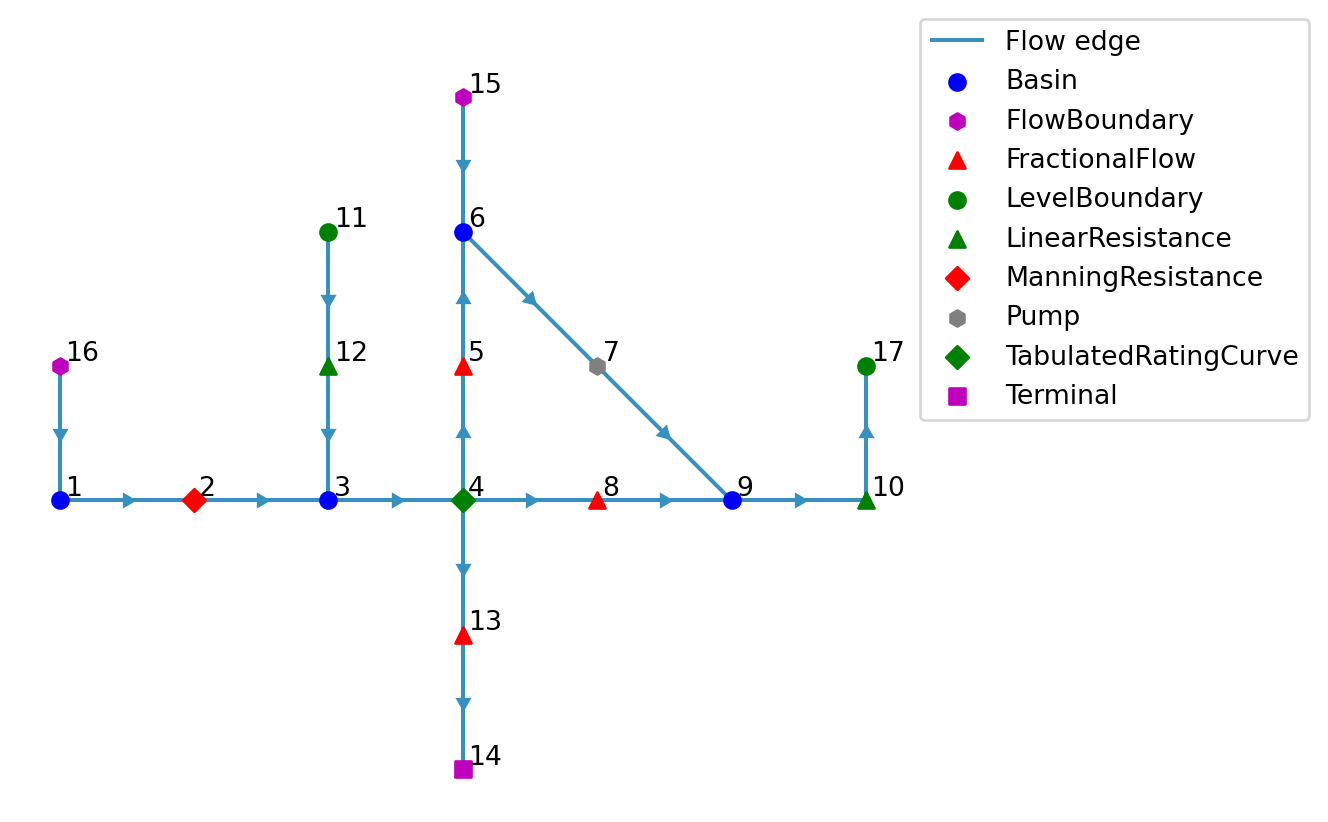

In [15]:
model.plot()

Write the model to a TOML and GeoPackage:

In [16]:
datadir = Path("data")
model.write(datadir / "basic")

# Update the basic model with transient forcing

This assumes you have already created the basic model with static forcing.

In [17]:
import numpy as np
import pandas as pd
import ribasim
import xarray as xr

In [18]:
model = ribasim.Model.from_toml(datadir / "basic/ribasim.toml")

In [19]:
time = pd.date_range(model.starttime, model.endtime)
day_of_year = time.day_of_year.to_numpy()
seconds_per_day = 24 * 60 * 60
evaporation = (
    (-1.0 * np.cos(day_of_year / 365.0 * 2 * np.pi) + 1.0) * 0.0025 / seconds_per_day
)
rng = np.random.default_rng(seed=0)
precipitation = (
    rng.lognormal(mean=-1.0, sigma=1.7, size=time.size) * 0.001 / seconds_per_day
)

We'll use xarray to easily broadcast the values.

In [20]:
timeseries = (
    pd.DataFrame(
        data={
            "node_id": 1,
            "time": time,
            "drainage": 0.0,
            "potential_evaporation": evaporation,
            "infiltration": 0.0,
            "precipitation": precipitation,
            "urban_runoff": 0.0,
        }
    )
    .set_index("time")
    .to_xarray()
)

basin_ids = model.basin.static["node_id"].to_numpy()
basin_nodes = xr.DataArray(
    np.ones(len(basin_ids)), coords={"node_id": basin_ids}, dims=["node_id"]
)
forcing = (timeseries * basin_nodes).to_dataframe().reset_index()

In [21]:
state = pd.DataFrame(
    data={
        "node_id": basin_ids,
        "level": 1.4,
        "concentration": 0.0,
    }
)

In [22]:
model.basin.time = forcing
model.basin.state = state

In [23]:
model.write(datadir / "basic_transient")

In [24]:
# | include: false
from subprocess import run

run(
    [
        "julia",
        "--project=../../core",
        "--eval",
        f'using Ribasim; Ribasim.run("{datadir.as_posix()}/basic_transient/ribasim.toml")',
    ],
    check=True,
)

CompletedProcess(args=['julia', '--project=../../core', '--eval', 'using Ribasim; Ribasim.run("data/basic_transient/ribasim.toml")'], returncode=0)

Now run the model with `ribasim basic-transient/ribasim.toml`.
After running the model, read back the results:

<Axes: xlabel='time'>

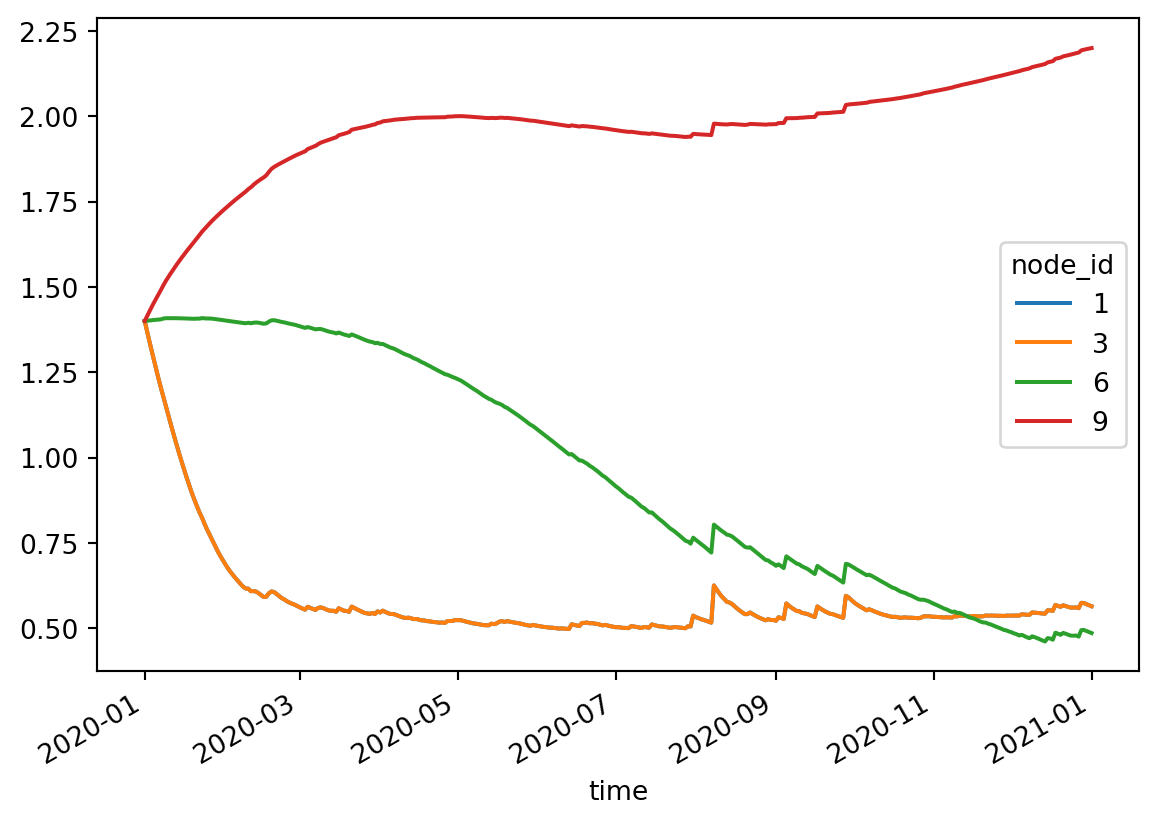

In [25]:
df_basin = pd.read_feather(datadir / "basic_transient/results/basin.arrow")
df_basin_wide = df_basin.pivot_table(
    index="time", columns="node_id", values=["storage", "level"]
)
df_basin_wide["level"].plot()

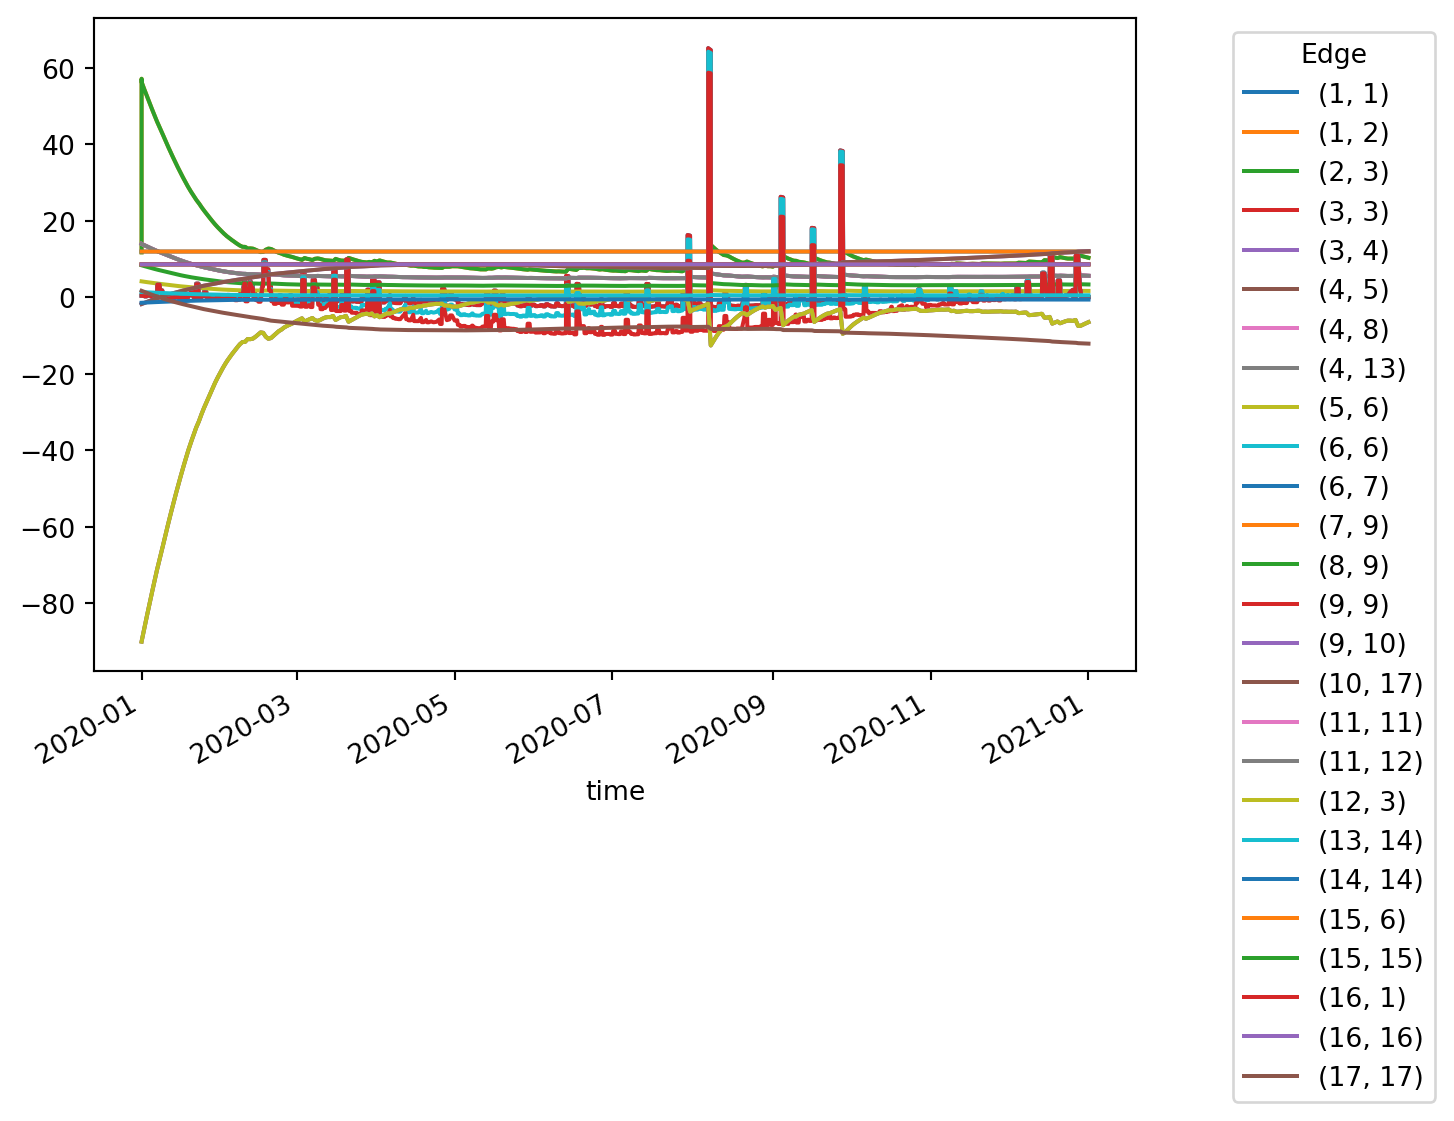

In [26]:
df_flow = pd.read_feather(datadir / "basic_transient/results/flow.arrow")
df_flow["edge"] = list(zip(df_flow.from_node_id, df_flow.to_node_id))
df_flow["flow_m3d"] = df_flow.flow * 86400
ax = df_flow.pivot_table(index="time", columns="edge", values="flow_m3d").plot()
ax.legend(bbox_to_anchor=(1.3, 1), title="Edge")

In [27]:
type(df_flow)

pandas.core.frame.DataFrame

# Model with discrete control

The model constructed below consists of a single basin which slowly drains trough a `TabulatedRatingCurve`, but is held within a range around a target level (setpoint) by two connected pumps. These two pumps behave like a reversible pump. When pumping can be done in only one direction, and the other direction is only possible under gravity, use an Outlet for that direction.

Set up the nodes:

In [28]:
xy = np.array(
    [
        (0.0, 0.0),  # 1: Basin
        (1.0, 1.0),  # 2: Pump
        (1.0, -1.0),  # 3: Pump
        (2.0, 0.0),  # 4: LevelBoundary
        (-1.0, 0.0),  # 5: TabulatedRatingCurve
        (-2.0, 0.0),  # 6: Terminal
        (1.0, 0.0),  # 7: DiscreteControl
    ]
)

node_xy = gpd.points_from_xy(x=xy[:, 0], y=xy[:, 1])

node_type = [
    "Basin",
    "Pump",
    "Pump",
    "LevelBoundary",
    "TabulatedRatingCurve",
    "Terminal",
    "DiscreteControl",
]

# Make sure the feature id starts at 1: explicitly give an index.
node = ribasim.Node(
    static=gpd.GeoDataFrame(
        data={"type": node_type},
        index=pd.Index(np.arange(len(xy)) + 1, name="fid"),
        geometry=node_xy,
        crs="EPSG:28992",
    )
)

Setup the edges:

In [29]:
from_id = np.array([1, 3, 4, 2, 1, 5, 7, 7], dtype=np.int64)
to_id = np.array([3, 4, 2, 1, 5, 6, 2, 3], dtype=np.int64)

edge_type = 6 * ["flow"] + 2 * ["control"]

lines = ribasim.utils.geometry_from_connectivity(node, from_id, to_id)
edge = ribasim.Edge(
    static=gpd.GeoDataFrame(
        data={"from_node_id": from_id, "to_node_id": to_id, "edge_type": edge_type},
        geometry=lines,
        crs="EPSG:28992",
    )
)

Setup the basins:

In [30]:
profile = pd.DataFrame(
    data={
        "node_id": [1, 1],
        "area": [1000.0, 1000.0],
        "level": [0.0, 1.0],
    }
)

static = pd.DataFrame(
    data={
        "node_id": [1],
        "drainage": [0.0],
        "potential_evaporation": [0.0],
        "infiltration": [0.0],
        "precipitation": [0.0],
        "urban_runoff": [0.0],
    }
)

state = pd.DataFrame(data={"node_id": [1], "level": [20.0]})

basin = ribasim.Basin(profile=profile, static=static, state=state)

Setup the discrete control:

In [31]:
condition = pd.DataFrame(
    data={
        "node_id": 3 * [7],
        "listen_feature_id": 3 * [1],
        "variable": 3 * ["level"],
        "greater_than": [5.0, 10.0, 15.0],  # min, setpoint, max
    }
)

logic = pd.DataFrame(
    data={
        "node_id": 5 * [7],
        "truth_state": ["FFF", "U**", "T*F", "**D", "TTT"],
        "control_state": ["in", "in", "none", "out", "out"],
    }
)

discrete_control = ribasim.DiscreteControl(condition=condition, logic=logic)

The above control logic can be summarized as follows:
- If the level gets above the maximum, activate the control state "out" until the setpoint is reached;
- If the level gets below the minimum, active the control state "in" until the setpoint is reached;
- Otherwise activate the control state "none".

Setup the pump:

In [32]:
pump = ribasim.Pump(
    static=pd.DataFrame(
        data={
            "node_id": 3 * [2] + 3 * [3],
            "control_state": 2 * ["none", "in", "out"],
            "flow_rate": [0.0, 2e-3, 0.0, 0.0, 0.0, 2e-3],
        }
    )
)

The pump data defines the following:

Control state | Pump #2 flow rate (m/s)| Pump #3 flow rate (m/s)
--------------|------------------------|------------------
"none"        | 0.0                    | 0.0
"in"          | 2e-3                   | 0.0
"out"         | 0.0                    | 2e-3

Setup the level boundary:

In [33]:
level_boundary = ribasim.LevelBoundary(
    static=pd.DataFrame(data={"node_id": [4], "level": [10.0]})
)

Setup the rating curve:

In [34]:
rating_curve = ribasim.TabulatedRatingCurve(
    static=pd.DataFrame(
        data={"node_id": 2 * [5], "level": [2.0, 15.0], "discharge": [0.0, 1e-3]}
    )
)

Setup the terminal:

In [35]:
terminal = ribasim.Terminal(static=pd.DataFrame(data={"node_id": [6]}))

Setup a model:

In [36]:
model = ribasim.Model(
    node=node,
    edge=edge,
    basin=basin,
    pump=pump,
    level_boundary=level_boundary,
    tabulated_rating_curve=rating_curve,
    terminal=terminal,
    discrete_control=discrete_control,
    starttime="2020-01-01 00:00:00",
    endtime="2021-01-01 00:00:00",
)

Let’s take a look at the model:

<Axes: >

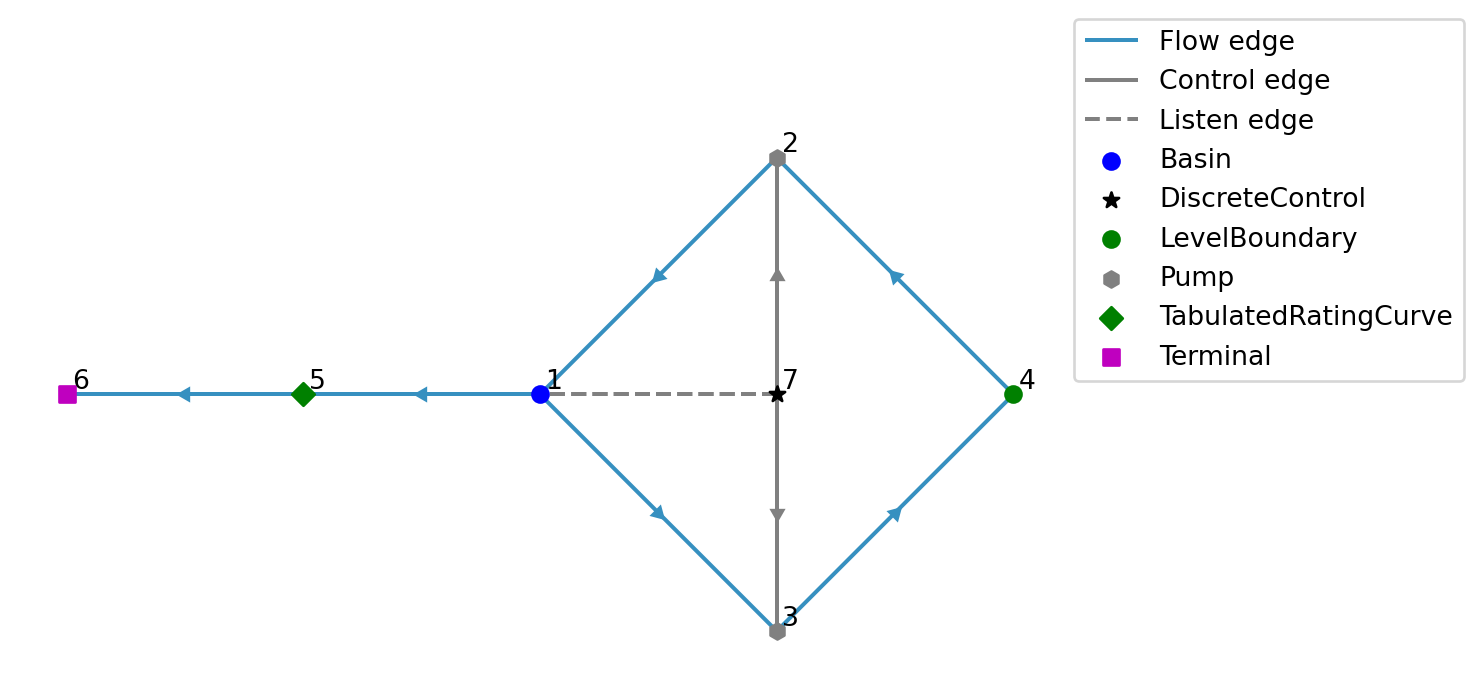

In [37]:
model.plot()

Listen edges are plotted with a dashed line since they are not present in the "Edge / static" schema but only in the "Control / condition" schema.

In [38]:
datadir = Path("data")
model.write(datadir / "level_setpoint_with_minmax")

In [39]:
# | include: false
from subprocess import run

run(
    [
        "julia",
        "--project=../../core",
        "--eval",
        f'using Ribasim; Ribasim.run("{datadir.as_posix()}/level_setpoint_with_minmax/ribasim.toml")',
    ],
    check=True,
)

CompletedProcess(args=['julia', '--project=../../core', '--eval', 'using Ribasim; Ribasim.run("data/level_setpoint_with_minmax/ribasim.toml")'], returncode=0)

Now run the model with `level_setpoint_with_minmax/ribasim.toml`.
After running the model, read back the results:

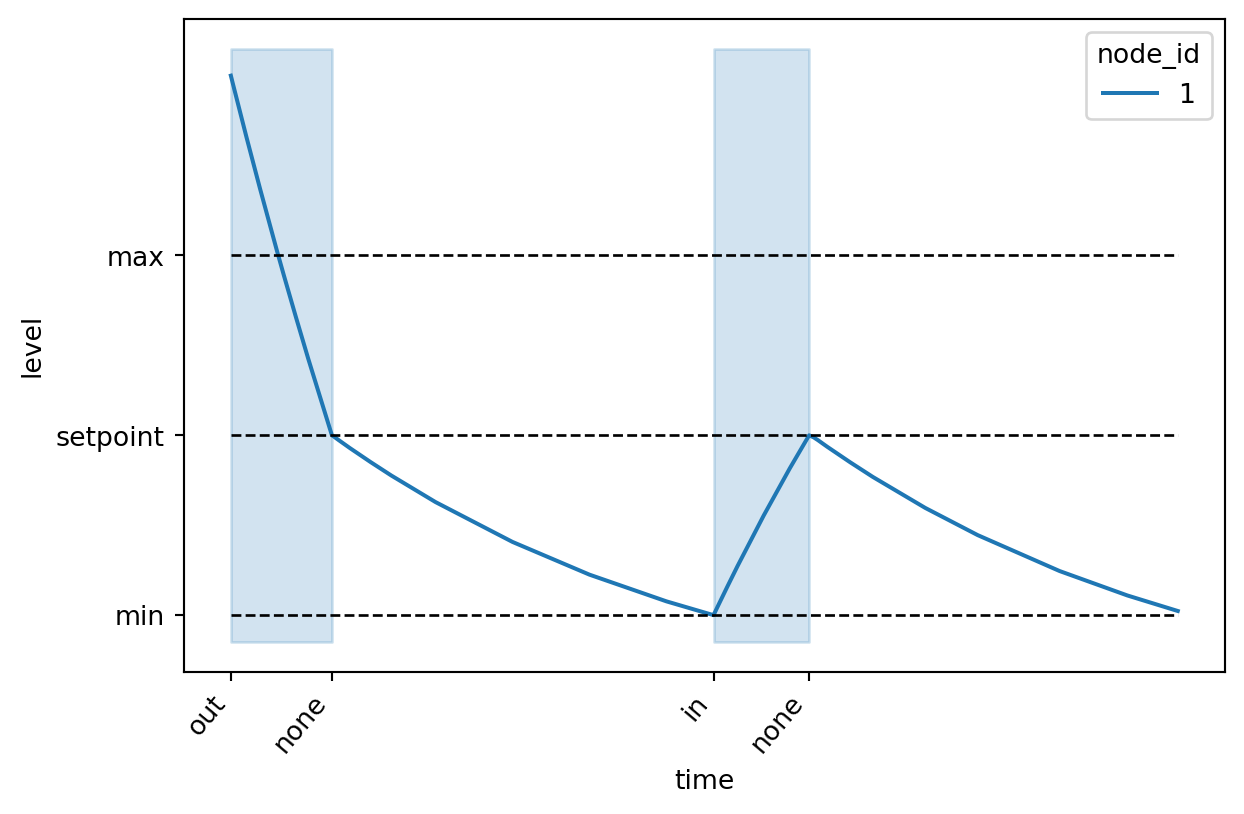

In [40]:
from matplotlib.dates import date2num

df_basin = pd.read_feather(datadir / "level_setpoint_with_minmax/results/basin.arrow")
df_basin_wide = df_basin.pivot_table(
    index="time", columns="node_id", values=["storage", "level"]
)

ax = df_basin_wide["level"].plot()

greater_than = model.discrete_control.condition.greater_than

ax.hlines(
    greater_than,
    df_basin.time[0],
    df_basin.time.max(),
    lw=1,
    ls="--",
    color="k",
)

df_control = pd.read_feather(
    datadir / "level_setpoint_with_minmax/results/control.arrow"
)

y_min, y_max = ax.get_ybound()
ax.fill_between(df_control.time[:2], 2 * [y_min], 2 * [y_max], alpha=0.2, color="C0")
ax.fill_between(df_control.time[2:4], 2 * [y_min], 2 * [y_max], alpha=0.2, color="C0")

ax.set_xticks(
    date2num(df_control.time).tolist(),
    df_control.control_state.tolist(),
    rotation=50,
)

ax.set_yticks(greater_than, ["min", "setpoint", "max"])
ax.set_ylabel("level")
plt.show()

The highlighted regions show where a pump is active.

Let's print an overview of what happened with control:

In [41]:
model.print_discrete_control_record(
    datadir / "level_setpoint_with_minmax/results/control.arrow"
)

0. At 2020-01-01 00:00:00 the control node with ID 7 reached truth state TTT:
	For node ID 1 (Basin): level > 5.0
	For node ID 1 (Basin): level > 10.0
	For node ID 1 (Basin): level > 15.0

   This yielded control state "out":
	For node ID 2 (Pump): flow_rate = 0.0
	For node ID 3 (Pump): flow_rate = 0.002

1. At 2020-02-09 01:17:29.324000 the control node with ID 7 reached truth state TFF:
	For node ID 1 (Basin): level > 5.0
	For node ID 1 (Basin): level < 10.0
	For node ID 1 (Basin): level < 15.0

   This yielded control state "none":
	For node ID 2 (Pump): flow_rate = 0.0
	For node ID 3 (Pump): flow_rate = 0.0

2. At 2020-07-05 13:24:51.165000 the control node with ID 7 reached truth state FFF:
	For node ID 1 (Basin): level < 5.0
	For node ID 1 (Basin): level < 10.0
	For node ID 1 (Basin): level < 15.0

   This yielded control state "in":
	For node ID 2 (Pump): flow_rate = 0.002
	For node ID 3 (Pump): flow_rate = 0.0

3. At 2020-08-11 11:49:59.015000 the control node with ID 7 reached

Note that crossing direction specific truth states (containing "U", "D") are not present in this overview even though they are part of the control logic. This is because in the control logic for this model these truth states are only used to sustain control states, while the overview only shows changes in control states.

# Model with PID control

Set up the nodes:

In [42]:
xy = np.array(
    [
        (0.0, 0.0),  # 1: FlowBoundary
        (1.0, 0.0),  # 2: Basin
        (2.0, 0.5),  # 3: Pump
        (3.0, 0.0),  # 4: LevelBoundary
        (1.5, 1.0),  # 5: PidControl
        (2.0, -0.5),  # 6: outlet
        (1.5, -1.0),  # 7: PidControl
    ]
)

node_xy = gpd.points_from_xy(x=xy[:, 0], y=xy[:, 1])

node_type = [
    "FlowBoundary",
    "Basin",
    "Pump",
    "LevelBoundary",
    "PidControl",
    "Outlet",
    "PidControl",
]

# Make sure the feature id starts at 1: explicitly give an index.
node = ribasim.Node(
    static=gpd.GeoDataFrame(
        data={"type": node_type},
        index=pd.Index(np.arange(len(xy)) + 1, name="fid"),
        geometry=node_xy,
        crs="EPSG:28992",
    )
)

Setup the edges:

In [43]:
from_id = np.array([1, 2, 3, 4, 6, 5, 7], dtype=np.int64)
to_id = np.array([2, 3, 4, 6, 2, 3, 6], dtype=np.int64)

lines = ribasim.utils.geometry_from_connectivity(node, from_id, to_id)
edge = ribasim.Edge(
    static=gpd.GeoDataFrame(
        data={
            "from_node_id": from_id,
            "to_node_id": to_id,
            "edge_type": 5 * ["flow"] + 2 * ["control"],
        },
        geometry=lines,
        crs="EPSG:28992",
    )
)

Setup the basins:

In [44]:
profile = pd.DataFrame(
    data={"node_id": [2, 2], "level": [0.0, 1.0], "area": [1000.0, 1000.0]}
)

static = pd.DataFrame(
    data={
        "node_id": [2],
        "drainage": [0.0],
        "potential_evaporation": [0.0],
        "infiltration": [0.0],
        "precipitation": [0.0],
        "urban_runoff": [0.0],
    }
)

state = pd.DataFrame(
    data={
        "node_id": [2],
        "level": [6.0],
    }
)

basin = ribasim.Basin(profile=profile, static=static, state=state)

Setup the pump:

In [45]:
pump = ribasim.Pump(
    static=pd.DataFrame(
        data={
            "node_id": [3],
            "flow_rate": [0.0],  # Will be overwritten by PID controller
        }
    )
)

Setup the outlet:

In [46]:
outlet = ribasim.Outlet(
    static=pd.DataFrame(
        data={
            "node_id": [6],
            "flow_rate": [0.0],  # Will be overwritten by PID controller
        }
    )
)

Setup flow boundary:

In [47]:
flow_boundary = ribasim.FlowBoundary(
    static=pd.DataFrame(data={"node_id": [1], "flow_rate": [1e-3]})
)

Setup flow boundary:

In [48]:
level_boundary = ribasim.LevelBoundary(
    static=pd.DataFrame(
        data={
            "node_id": [4],
            "level": [1.0],  # Not relevant
        }
    )
)

Setup PID control:

In [49]:
pid_control = ribasim.PidControl(
    time=pd.DataFrame(
        data={
            "node_id": 4 * [5, 7],
            "time": [
                "2020-01-01 00:00:00",
                "2020-01-01 00:00:00",
                "2020-05-01 00:00:00",
                "2020-05-01 00:00:00",
                "2020-07-01 00:00:00",
                "2020-07-01 00:00:00",
                "2020-12-01 00:00:00",
                "2020-12-01 00:00:00",
            ],
            "listen_node_id": 4 * [2, 2],
            "target": [5.0, 5.0, 5.0, 5.0, 7.5, 7.5, 7.5, 7.5],
            "proportional": 4 * [-1e-3, 1e-3],
            "integral": 4 * [-1e-7, 1e-7],
            "derivative": 4 * [0.0, 0.0],
        }
    )
)

Note that the coefficients for the pump and the outlet are equal in magnitude but opposite in sign. This way the pump and the outlet equally work towards the same goal, while having opposite effects on the controlled basin due to their connectivity to this basin.

Setup a model:

In [50]:
model = ribasim.Model(
    node=node,
    edge=edge,
    basin=basin,
    flow_boundary=flow_boundary,
    level_boundary=level_boundary,
    pump=pump,
    outlet=outlet,
    pid_control=pid_control,
    starttime="2020-01-01 00:00:00",
    endtime="2020-12-01 00:00:00",
)

Let's take a look at the model:

<Axes: >

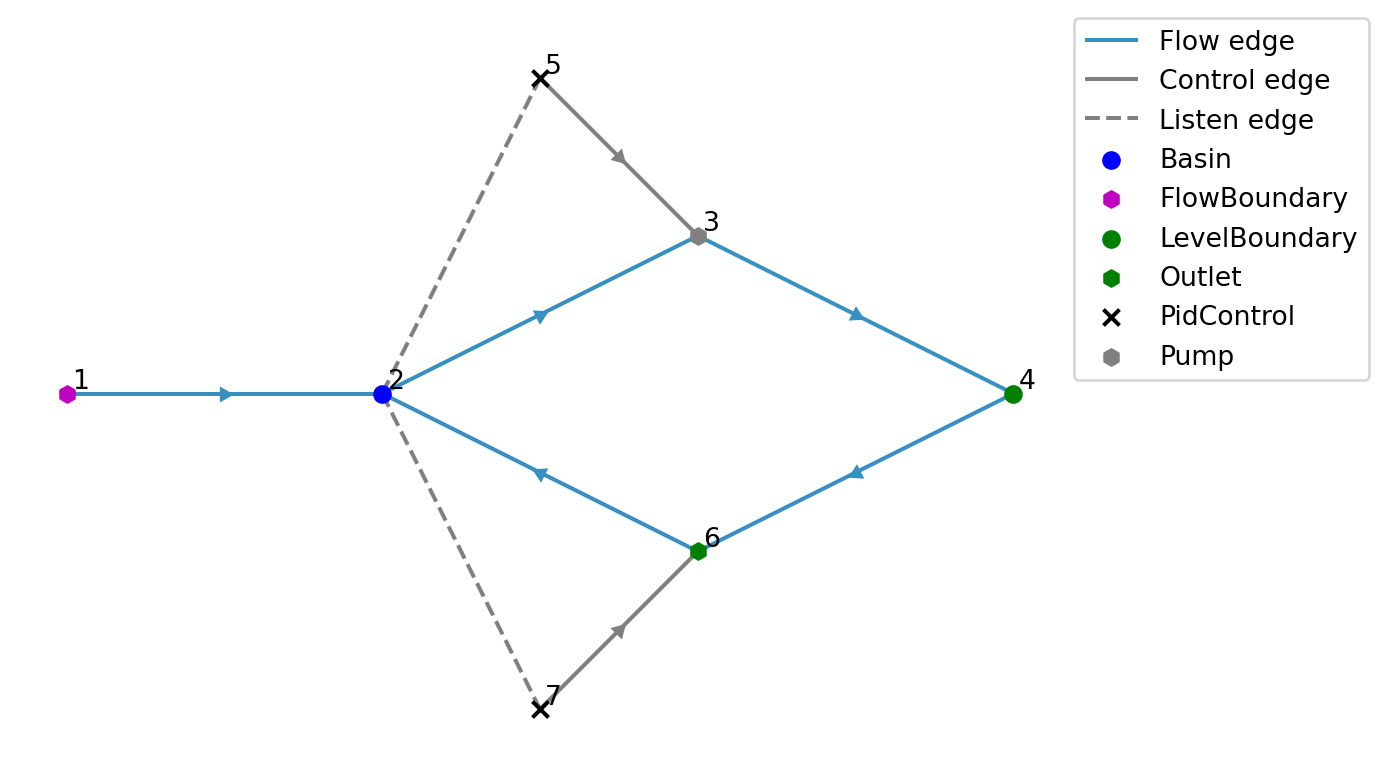

In [51]:
model.plot()

Write the model to a TOML and GeoPackage:

In [52]:
datadir = Path("data")
model.write(datadir / "pid_control")

In [53]:
# | include: false
from subprocess import run

run(
    [
        "julia",
        "--project=../../core",
        "--eval",
        f'using Ribasim; Ribasim.run("{datadir.as_posix()}/pid_control/ribasim.toml")',
    ],
    check=True,
)

CompletedProcess(args=['julia', '--project=../../core', '--eval', 'using Ribasim; Ribasim.run("data/pid_control/ribasim.toml")'], returncode=0)

Now run the model with `ribasim pid_control/ribasim.toml`.
After running the model, read back the results:

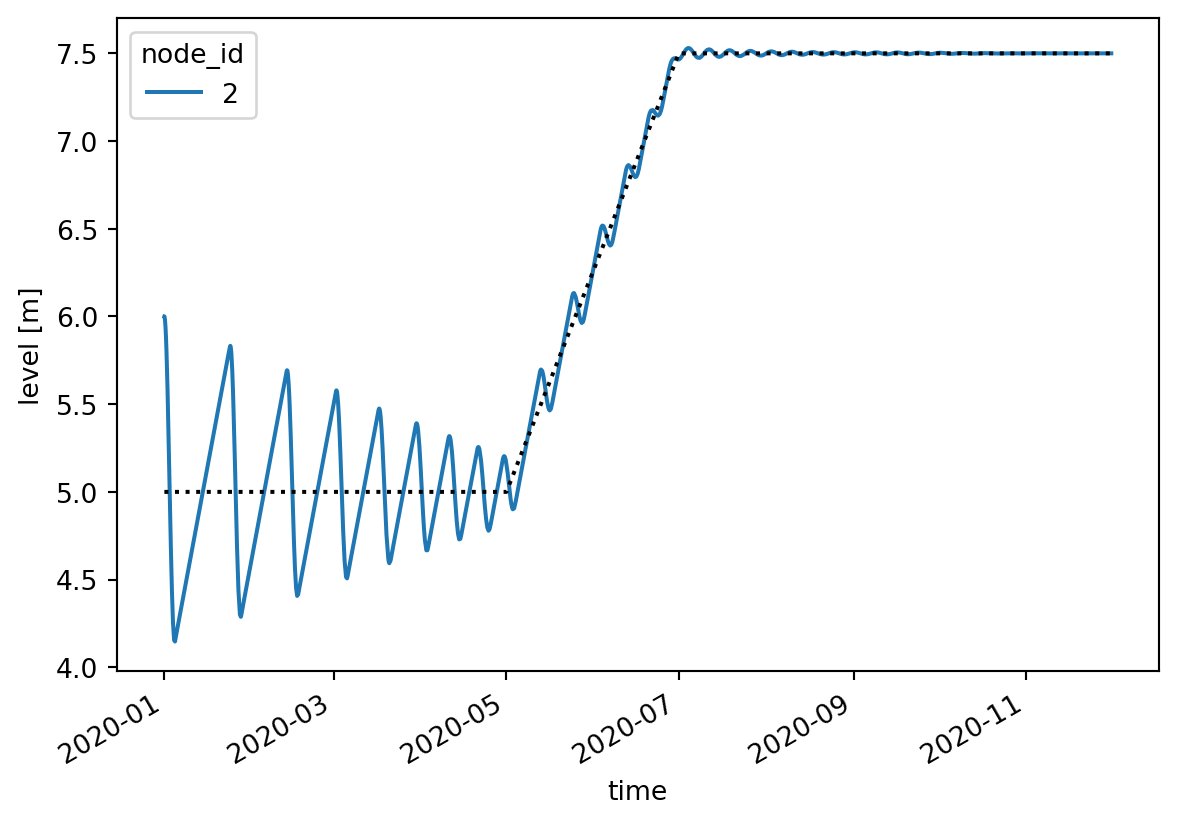

In [54]:
from matplotlib.dates import date2num

df_basin = pd.read_feather(datadir / "pid_control/results/basin.arrow")
df_basin_wide = df_basin.pivot_table(
    index="time", columns="node_id", values=["storage", "level"]
)
ax = df_basin_wide["level"].plot()
ax.set_ylabel("level [m]")

# Plot target level
target_levels = model.pid_control.time.target.to_numpy()[::2]
times = date2num(model.pid_control.time.time)[::2]
ax.plot(times, target_levels, color="k", ls=":", label="target level")
pass